In [2]:
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models
torch.cuda.empty_cache()

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi 

Fri Mar 25 13:14:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **Loading VGG19**

In [5]:
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters 
for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [6]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
vgg.to(device)


True


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

# **Load Images**

In [7]:
%ls
%cd drive/MyDrive/TRIED/ProjetLong
%ls

drive/  sample_data/
/content/drive/MyDrive/TRIED/ProjetLong
maisons.jpg   moi.jpg    nuitet.jpg  van.jpg  wow.jpg
minotaur.jpg  neige.jpg  paris.jpg   VII.jpg


In [23]:
def load_image(img_path, shape):
    
    image = Image.open(img_path).convert('RGB')
    
    # large images slow down processing
    in_transform = transforms.Compose([
                        transforms.Resize(shape),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    
    return image

In [33]:

# load in content and style image
content = load_image('neige.jpg', shape=256).to(device)
style = load_image('vague.jpg', shape=content.shape[-2:]).to(device)


In [25]:

def im_convert(tensor):
    #Tensor to image    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image


(256, 256, 3)


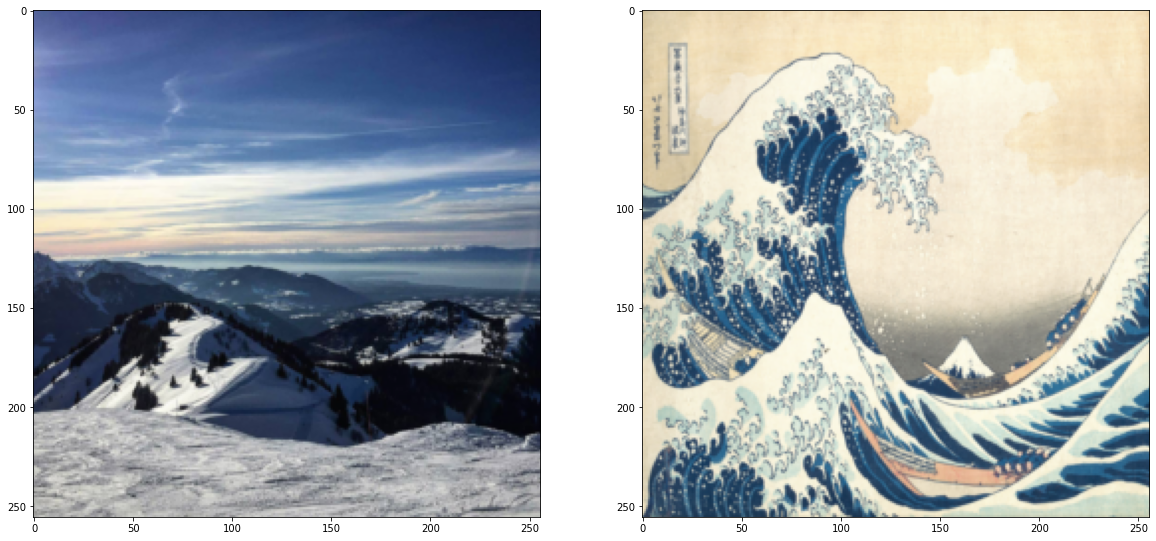

In [34]:
# display the images
print(im_convert(content).shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(style))

* Layers

In [27]:
def get_features(image, model):
    layers = {'0': 'conv1_1',
                 '5':  'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

* Gram

In [28]:
def gram_matrix(tensor):  
    b, d, h, w = tensor.size()
    tensor = tensor.view(d, h*w)
    gram = torch.mm(tensor, tensor.t())
    return gram

* Get features, calculate gram and create target


torch.Size([1, 3, 256, 256])


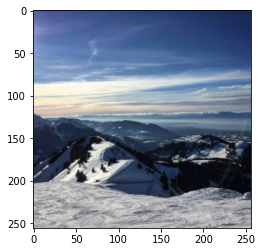

In [38]:
# get content and style features 
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

#create the target image
target = content.clone().requires_grad_(True).to(device)
print(target.shape)
#target = torch.rand(size = content.shape, requires_grad=True, device=device )

plt.imshow(im_convert(target))


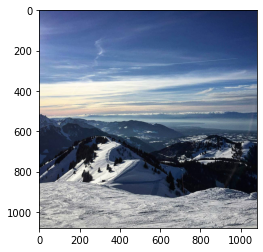

In [30]:
plt.imshow(im_convert(target))

# Losses

In [39]:
# weights for each style layer 

style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.8,
                 'conv3_1': 0.5,
                 'conv4_1': 0.3,
                 'conv5_1': 0.1}

content_weight = 1 # alpha
style_weight =  1000 # beta

Total loss:  4564.12060546875


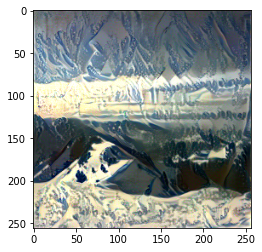

Total loss:  2563.53564453125


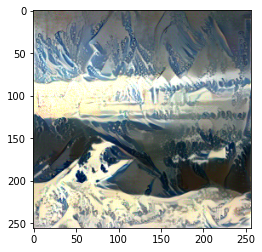

Total loss:  1754.5078125


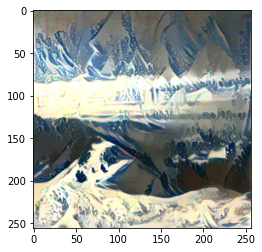

Total loss:  1805.6903076171875


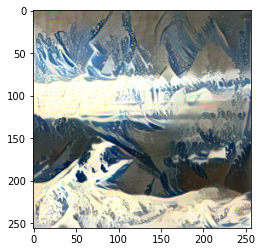

Total loss:  1069.62890625


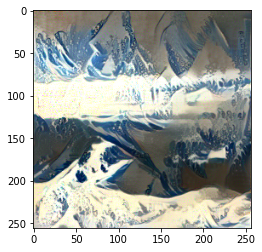

Total loss:  1166.375244140625


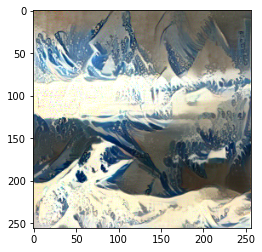

Total loss:  2155.723388671875


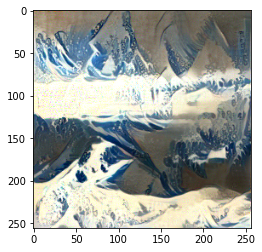

Total loss:  909.02294921875


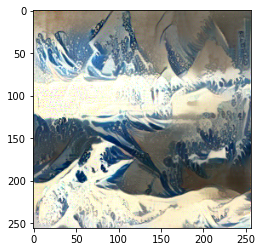

Total loss:  847.937744140625


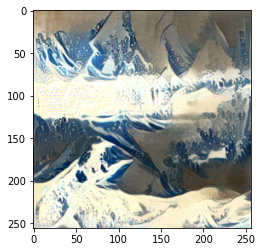

Total loss:  700.2779541015625


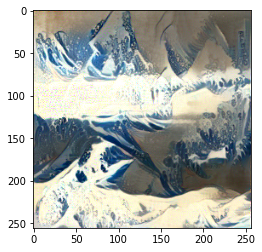

--- 102.47701215744019 seconds ---


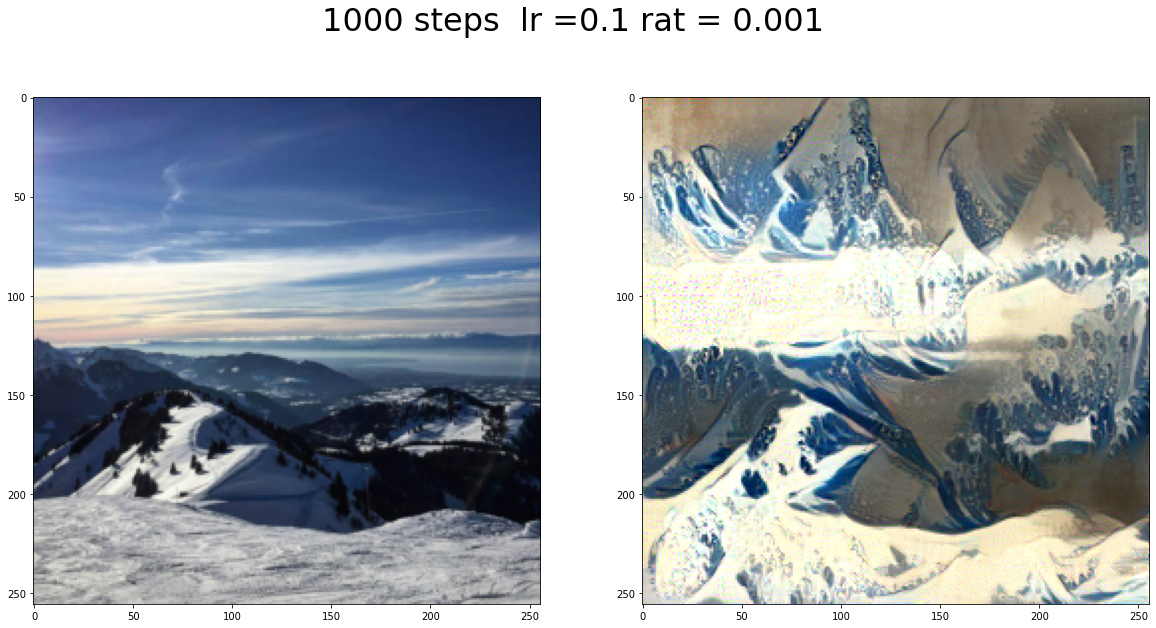

In [40]:
show_every = 100
learning_rate = 0.1

optimizer = optim.Adam([target], lr=learning_rate)

steps = 1000  #iterations
import time
start_time = time.time()
for ii in range(1, steps+1):
        
    #content loss
    target_features = get_features(target, vgg)
    content_loss = torch.mean((target_features["conv4_2"] - content_features["conv4_2"]) ** 2)
    
    #style loss
   
    style_loss = 0
   
    for layer in style_weights:
        
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        
        
        style_loss += layer_style_loss / (d * h * w)
       
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()
print("--- %s seconds ---" % (time.time() - start_time))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f'{steps} steps  lr ={learning_rate} rat = {content_weight/style_weight}', fontsize=32)
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))